# User Type corollary to the Lyft Bike Sharing System - San Francisco Bay Area
## by Karan Bhardwaj

### Investigation Overview

##### In this investigation, I wanted to look at how the different User Type i.e. Subscriber or Customer make use of the ride sharing system. I will also investigate when are most trips taken in terms of time of day, day of the week, or month of the year?

### Dataset Overview
##### This is data of 4554806 rides of Ford GoBike System data starting from June 2017 until October 2019 for San Francisco Bay Area.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import calendar
from math import log
%matplotlib inline
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
path = r'C:\Users\kbhardwaj\Downloads\Udacity\DA\Communicate Data Findings' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=None, engine='python')
    li.append(df)

goBike = pd.concat(li, axis=0, ignore_index=True,sort=True)

In [3]:
#change datatype of start_time column from str to timestamp
goBike['start_time'] =pd.to_datetime(goBike.start_time, format="%Y-%m-%d %H:%M:%S.%f")
print(type(goBike['start_time'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
#create custom fields for in depth analysis
goBike['start_time_hour'] = goBike['start_time'].dt.hour
goBike['start_time_month'] = goBike['start_time'].dt.month
goBike['start_time_month'] = goBike['start_time_month'].apply(lambda x: calendar.month_abbr[x])
goBike['start_time_year'] = goBike['start_time'].dt.year
goBike['start_time_weekday'] = goBike['start_time'].dt.weekday_name
goBike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 21 columns):
bike_id                    int64
bike_share_for_all_trip    object
duration_sec               int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name           object
end_time                   object
member_birth_year          float64
member_gender              object
rental_access_method       object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name         object
start_time                 datetime64[ns]
user_type                  object
start_time_hour            int64
start_time_month           object
start_time_year            int64
start_time_weekday         object
dtypes: datetime64[ns](1), float64(7), int64(4), object(9)
memory usage: 729.8+ MB


In [5]:
goBike['start_time_year'] = goBike['start_time_year'].astype(str)

In [6]:
# convert start_time_month and start_time_weekday into ordered categorical types
ordinal_var_dict = {'start_time_month': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                    'start_time_weekday': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
                   'start_time_year':['2017','2018','2019']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    goBike[var] = goBike[var].astype(ordered_var)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

### Distribution of Ride Duration and Average Ride Duration

Ride Duration in the dataset take on a very large range of values, from about **50** seconds at the lowest, to about **86,000** seconds at the highest. Plotted on a logarithmic scale, the distribution of ride duration takes on a unimodal shape.

Average Ride Duration of the dataset is ~__860__ seconds while when broken by User Type _Subscriber_ ride duration mean is ~**675** seconds i.e. approximately 3 times less than _Customer_ ride duration mean of ~**1787** seconds.

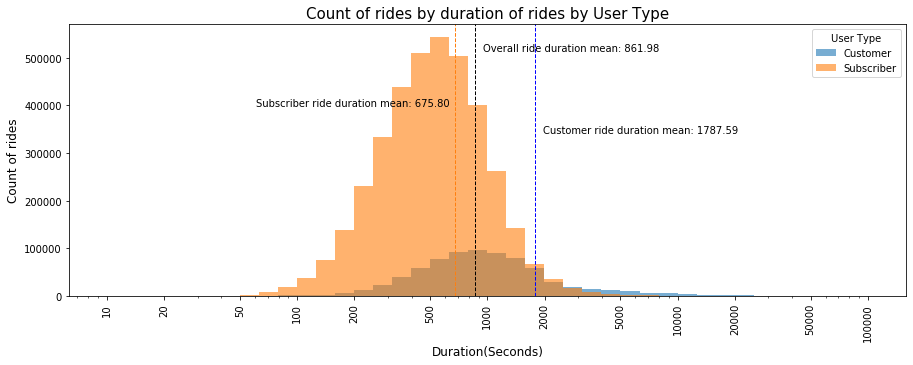

In [7]:
goBike_groupedBy_UserType = goBike.groupby('user_type').duration_sec
bin_edges = 10 ** np.arange(1, 5+.1,.1)
goBike_groupedBy_UserType.plot(kind='hist',figsize=[15,5],alpha=.6,legend=True,bins = bin_edges);
plt.xscale('log');
tick_locs = [10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000];
plt.xticks(tick_locs, tick_locs);
plt.xticks(rotation=90);
plt.title('Count of rides by duration of rides by User Type',fontsize=15)
plt.xlabel('Duration(Seconds)',fontsize=12);
plt.ylabel('Count of rides',fontsize=12);
plt.legend(title = 'User Type');
min_ylim, max_ylim = plt.ylim()
plt.axvline(goBike[goBike['user_type']=='Customer'].duration_sec.mean(), color='b', linestyle='dashed', linewidth=1);
plt.text(goBike[goBike['user_type']=='Customer'].duration_sec.mean()*1.1, max_ylim*0.6, 'Customer ride duration mean: {:.2f}'.format(goBike[goBike['user_type']=='Customer'].duration_sec.mean()));
plt.axvline(goBike[goBike['user_type']=='Subscriber'].duration_sec.mean(), color='tab:orange', linestyle='dashed', linewidth=1);
plt.text(goBike[goBike['user_type']=='Subscriber'].duration_sec.mean()*.09, max_ylim*0.7, 'Subscriber ride duration mean: {:.2f}'.format(goBike[goBike['user_type']=='Subscriber'].duration_sec.mean()));
plt.axvline(goBike['duration_sec'].mean(), color='k', linestyle='dashed', linewidth=1);
plt.text(goBike['duration_sec'].mean()*1.1, max_ylim*0.9, 'Overall ride duration mean: {:.2f}'.format(goBike['duration_sec'].mean()));

### Distribution of Count of Rides and Ride Duration Distribution by User Type.

Subscribers use the Ford GoBike sharing services ~**60%** more than Casual Customers but interestingly Subscribers _median_ ride duration is **less** than _lower 25%_ of ride duration value for that of Customers. 

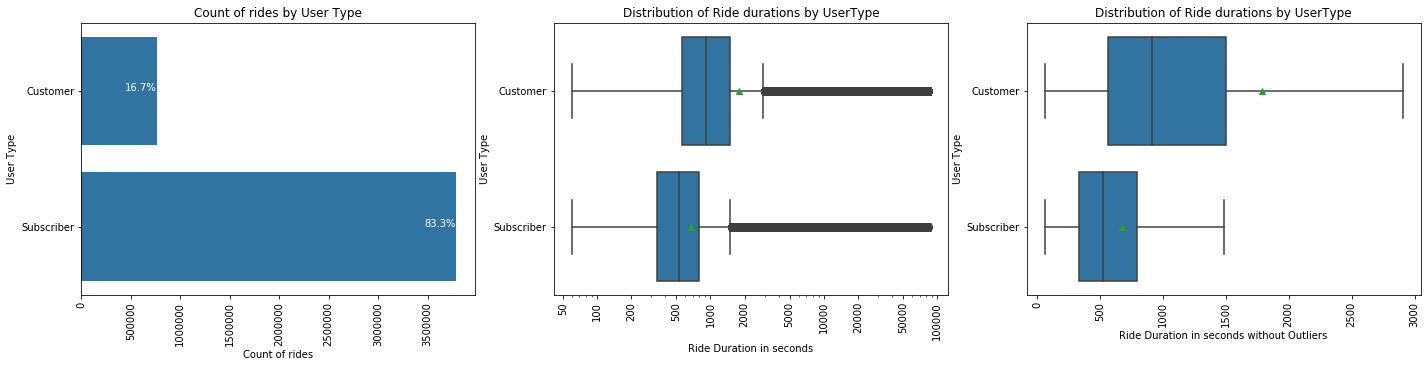

In [8]:
plt.figure(figsize = [24, 5])
default_color = sb.color_palette()[0]
plt.subplot(1, 3, 1)
sb.countplot(data = goBike, y = 'user_type', color = default_color);
plt.xticks(rotation=90)
plt.title('Count of rides by User Type',fontsize=12)
plt.xlabel('Count of rides',fontsize=10);
plt.ylabel('User Type',fontsize=10);

# add annotations
n_points = goBike.shape[0]
cat_counts = goBike['user_type'].value_counts()
locs, labels = plt.yticks() 
for loc, label in zip(locs, labels):
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)
    plt.text(count-320000,loc, pct_string, color = 'w')

plt.subplot(1, 3, 2)
sb.boxplot(data = goBike, y = 'user_type', x = 'duration_sec', color = default_color,showmeans=True);
plt.xscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000,100000];
plt.xticks(tick_locs, tick_locs);
plt.xticks(rotation=90)
plt.title('Distribution of Ride durations by UserType',fontsize=12)
plt.xlabel('Ride Duration in seconds',fontsize=10);
plt.ylabel('User Type',fontsize=10);

plt.subplot(1, 3, 3)
sb.boxplot(data = goBike, y = 'user_type', x = 'duration_sec', color = default_color,showmeans=True,showfliers=False);
plt.xticks(rotation=90)
plt.title('Distribution of Ride durations by UserType',fontsize=12)
plt.xlabel('Ride Duration in seconds without Outliers',fontsize=10);
plt.ylabel('User Type',fontsize=10);


### Distribution of Count of Rides by Hour of the day, Day of the week at cumulative and User Type level.

- Most of the trips in day are taken during the start and end of normal working day hours i.e. 8AM-9AM and 5PM-6PM. 

- Interestingly, while there is dip in rides during 11AM for subscribers there is rise in rides during the same time for customers.

- At cumulative level and for subscriber user type most of the rides are during weekdays and there is a dip over the weekend but in case of customer user type maximum rides are on Saturday and there is rise in rides over weekend in comparison with weekdays.

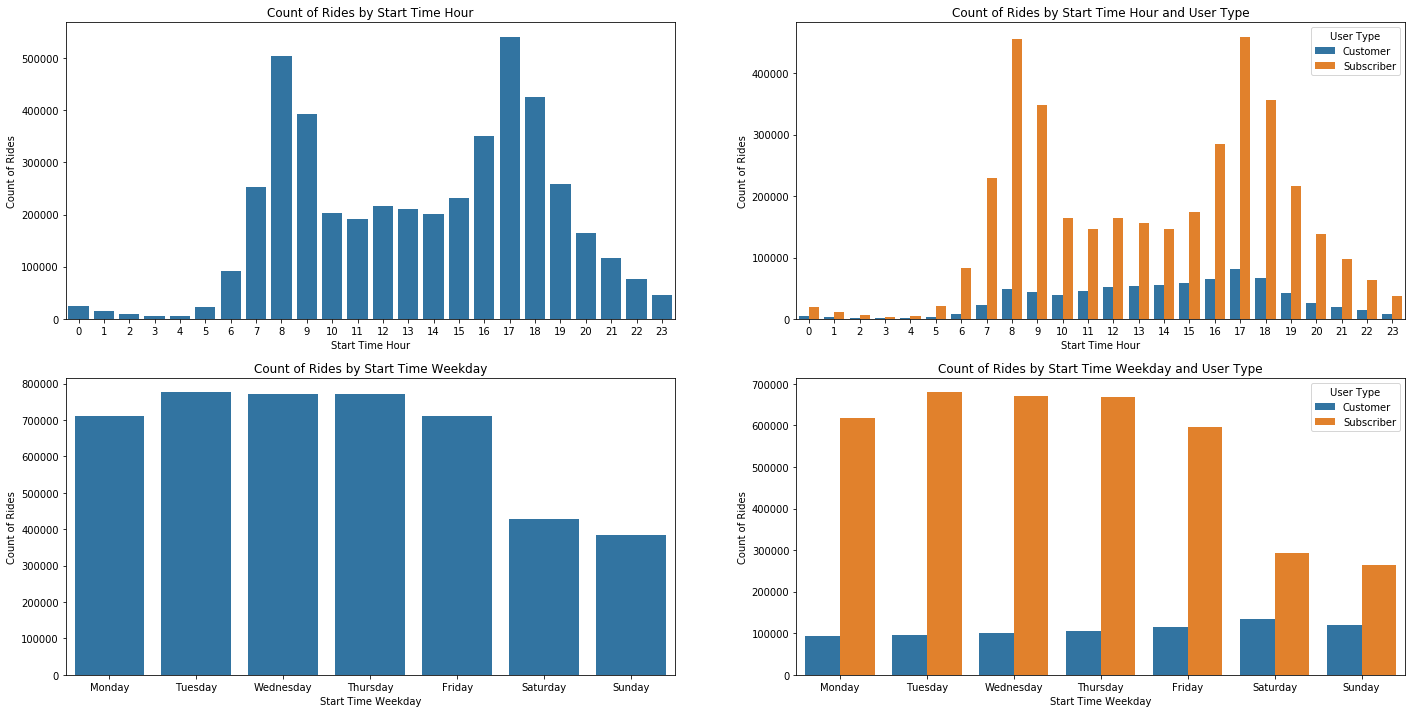

In [9]:
plt.figure(figsize = [24, 12])
default_color = sb.color_palette()[0]
plt.subplot(221)
sb.countplot(data = goBike, x = 'start_time_hour', color = default_color);
plt.title('Count of Rides by Start Time Hour',fontsize=12)
plt.ylabel('Count of Rides',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(222)
sb.countplot(data = goBike, x = 'start_time_hour',hue='user_type');
plt.title('Count of Rides by Start Time Hour and User Type',fontsize=12)
plt.ylabel('Count of Rides',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);
plt.legend(title = 'User Type');

plt.subplot(223)
sb.countplot(data = goBike, x = 'start_time_weekday', color = default_color);
plt.title('Count of Rides by Start Time Weekday',fontsize=12)
plt.ylabel('Count of Rides',fontsize=10);
plt.xlabel('Start Time Weekday',fontsize=10);

plt.subplot(224)
sb.countplot(data = goBike, x = 'start_time_weekday', hue='user_type');
plt.title('Count of Rides by Start Time Weekday and User Type',fontsize=12)
plt.ylabel('Count of Rides',fontsize=10);
plt.xlabel('Start Time Weekday',fontsize=10);
plt.legend(title = 'User Type');


### Distribution of Ride Duration Distribution by Hour of the day, Day of the week and Month of the year and also by User Type.

Ride duration distribution by Hour of the day, Day of the week and Month of the year __resemble__ the initial finding above of the cumulative Ride duration distribution by User Type i.e. *__Customers__ use the GoBike ride sharing system for longer duration in comparison with __Subscribers__ irrespective of hour of the day, day of the week or month of the year.*

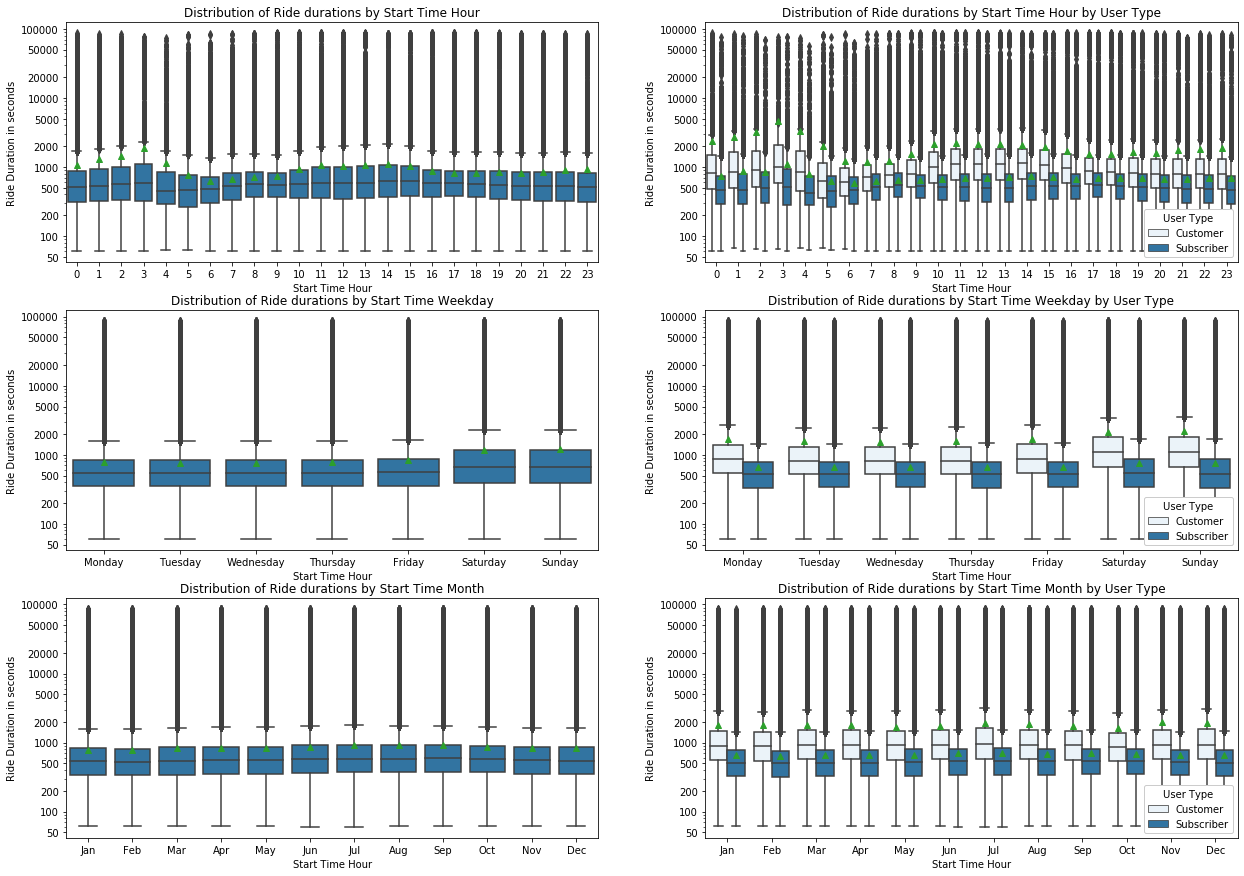

In [10]:
plt.figure(figsize = [21, 15])
default_color = sb.color_palette()[0]
plt.subplot(321)
sb.boxplot(data = goBike, x = 'start_time_hour', y = 'duration_sec', color = default_color,showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
plt.title('Distribution of Ride durations by Start Time Hour',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(322)
ax=sb.boxplot(data = goBike, x = 'start_time_hour', y = 'duration_sec', color = default_color, hue='user_type',showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
ax.legend(loc = 4, ncol = 1, framealpha = 1, title="User Type");
plt.title('Distribution of Ride durations by Start Time Hour by User Type',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(323)
sb.boxplot(data = goBike, x = 'start_time_weekday', y = 'duration_sec', color = default_color,showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
plt.title('Distribution of Ride durations by Start Time Weekday',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(324)
ax=sb.boxplot(data = goBike, x = 'start_time_weekday', y = 'duration_sec', color = default_color, hue='user_type',showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
ax.legend(loc = 4, ncol = 1, framealpha = 1, title="User Type");
plt.title('Distribution of Ride durations by Start Time Weekday by User Type',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(325)
sb.boxplot(data = goBike, x = 'start_time_month', y = 'duration_sec', color = default_color,showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
plt.title('Distribution of Ride durations by Start Time Month',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);

plt.subplot(326)
ax=sb.boxplot(data = goBike, x = 'start_time_month', y = 'duration_sec', color = default_color, hue='user_type',showmeans=True);
plt.yscale('log');
tick_locs = [50,100,200,500,1000,2000,5000,10000,20000,50000, 100000];
plt.yticks(tick_locs, tick_locs);
ax.legend(loc = 4, ncol = 1, framealpha = 1, title="User Type");
plt.title('Distribution of Ride durations by Start Time Month by User Type',fontsize=12)
plt.ylabel('Ride Duration in seconds',fontsize=10);
plt.xlabel('Start Time Hour',fontsize=10);